# Fourier Domain Adaptation (FDA) for Crop Classification

**Purpose**: Adapt PASTIS (France) imagery to have Algerian spectral characteristics while preserving crop structure.

## FDA Process:
1. **FFT Decomposition**: Separate images into Amplitude (style) and Phase (structure)
2. **Low-Frequency Swap**: Replace source low-frequencies with target low-frequencies
3. **Reconstruction**: Combine mixed amplitude with original phase via inverse FFT

## Key Parameters:
- **Beta (β)**: Controls the size of the low-frequency window to swap (typically 0.01-0.05)
- Smaller β = subtle color shift, larger β = stronger adaptation (but risk of artifacts)

## Data:
- **Source (PASTIS)**: 2433 patches from France - shape (1, 10, 128, 128)
- **Target (Algeria)**: 193 patches from Algeria - shape (1, 10, 128, 128)
- **Output**: FDA-adapted PASTIS images with Algerian spectral characteristics

In [1]:
# Setup and imports
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from tqdm import tqdm
import random
import shutil

# Define paths
SOURCE_DIR = Path('/home/crop/Desktop/crop2/output/pastis_maxndvi/DATA_S2')  # PASTIS (France)
TARGET_DIR = Path('/home/crop/Desktop/crop2/output/algeria_s2_data/DATA_S2')  # Algeria

# Output directory for FDA-adapted images
OUTPUT_DIR = Path('/home/crop/Desktop/crop2/output/fda_adapted')
OUTPUT_DATA_DIR = OUTPUT_DIR / 'DATA_S2'
OUTPUT_ANN_DIR = OUTPUT_DIR / 'ANNOTATIONS'

OUTPUT_DATA_DIR.mkdir(parents=True, exist_ok=True)
OUTPUT_ANN_DIR.mkdir(parents=True, exist_ok=True)

# Load file lists
source_files = sorted(SOURCE_DIR.glob('*.npy'))
target_files = sorted(TARGET_DIR.glob('*.npy'))

print(f"Source (PASTIS) files: {len(source_files)}")
print(f"Target (Algeria) files: {len(target_files)}")

# Verify shapes
sample_source = np.load(source_files[0])
sample_target = np.load(target_files[0])
print(f"\nSource shape: {sample_source.shape}")
print(f"Target shape: {sample_target.shape}")

Source (PASTIS) files: 2433
Target (Algeria) files: 193

Source shape: (1, 10, 128, 128)
Target shape: (1, 10, 128, 128)


In [2]:
# FDA Core Functions

def fda_transfer(source_img, target_img, beta=0.01):
    """
    Apply Fourier Domain Adaptation to transfer low-frequency (style) 
    from target to source while keeping source structure (phase).
    
    Args:
        source_img: Source image array (C, H, W) - PASTIS
        target_img: Target image array (C, H, W) - Algeria  
        beta: Size of low-frequency window (0.01 = 1% of spectrum)
    
    Returns:
        FDA-adapted image with target style and source structure
    """
    # Ensure float32 for FFT
    source = source_img.astype(np.float32)
    target = target_img.astype(np.float32)
    
    C, H, W = source.shape
    
    # Process each band independently
    adapted = np.zeros_like(source)
    
    for c in range(C):
        # 2D FFT and shift to center low frequencies
        src_fft = np.fft.fft2(source[c])
        src_fft_shifted = np.fft.fftshift(src_fft)
        
        tgt_fft = np.fft.fft2(target[c])
        tgt_fft_shifted = np.fft.fftshift(tgt_fft)
        
        # Separate amplitude and phase
        src_amp = np.abs(src_fft_shifted)
        src_phase = np.angle(src_fft_shifted)
        
        tgt_amp = np.abs(tgt_fft_shifted)
        
        # Define low-frequency window (center of spectrum)
        h_center, w_center = H // 2, W // 2
        h_beta = int(H * beta)
        w_beta = int(W * beta)
        
        # Ensure at least 1 pixel window
        h_beta = max(1, h_beta)
        w_beta = max(1, w_beta)
        
        # Create mixed amplitude: replace center (low-freq) with target
        mixed_amp = src_amp.copy()
        mixed_amp[h_center - h_beta:h_center + h_beta + 1,
                  w_center - w_beta:w_center + w_beta + 1] = \
            tgt_amp[h_center - h_beta:h_center + h_beta + 1,
                    w_center - w_beta:w_center + w_beta + 1]
        
        # Reconstruct with mixed amplitude and original source phase
        mixed_fft = mixed_amp * np.exp(1j * src_phase)
        
        # Inverse FFT
        mixed_fft_unshifted = np.fft.ifftshift(mixed_fft)
        adapted[c] = np.real(np.fft.ifft2(mixed_fft_unshifted))
    
    return adapted


def visualize_fft_components(img, title=""):
    """Visualize amplitude and phase of an image"""
    fig, axes = plt.subplots(1, 3, figsize=(12, 4))
    
    # Use band 4 (Red) for visualization
    band = img[2] if len(img.shape) == 3 else img[0, 2]
    
    # Original
    axes[0].imshow(band, cmap='gray')
    axes[0].set_title(f'{title} - Original (B4)')
    axes[0].axis('off')
    
    # FFT
    fft = np.fft.fftshift(np.fft.fft2(band))
    
    # Amplitude (log scale for visibility)
    axes[1].imshow(np.log1p(np.abs(fft)), cmap='hot')
    axes[1].set_title('Amplitude (log)')
    axes[1].axis('off')
    
    # Phase
    axes[2].imshow(np.angle(fft), cmap='twilight')
    axes[2].set_title('Phase')
    axes[2].axis('off')
    
    plt.tight_layout()
    return fig


# Test the FDA function on a single pair
print("Testing FDA on single image pair...")
source_sample = np.load(source_files[0])[0]  # Remove batch dim: (10, 128, 128)
target_sample = np.load(target_files[0])[0]  # Remove batch dim: (10, 128, 128)

adapted_sample = fda_transfer(source_sample, target_sample, beta=0.01)

print(f"Source range: [{source_sample.min():.0f}, {source_sample.max():.0f}]")
print(f"Target range: [{target_sample.min():.0f}, {target_sample.max():.0f}]")
print(f"Adapted range: [{adapted_sample.min():.0f}, {adapted_sample.max():.0f}]")

Testing FDA on single image pair...
Source range: [-692, 5935]
Target range: [323, 4922]
Adapted range: [-166, 7020]


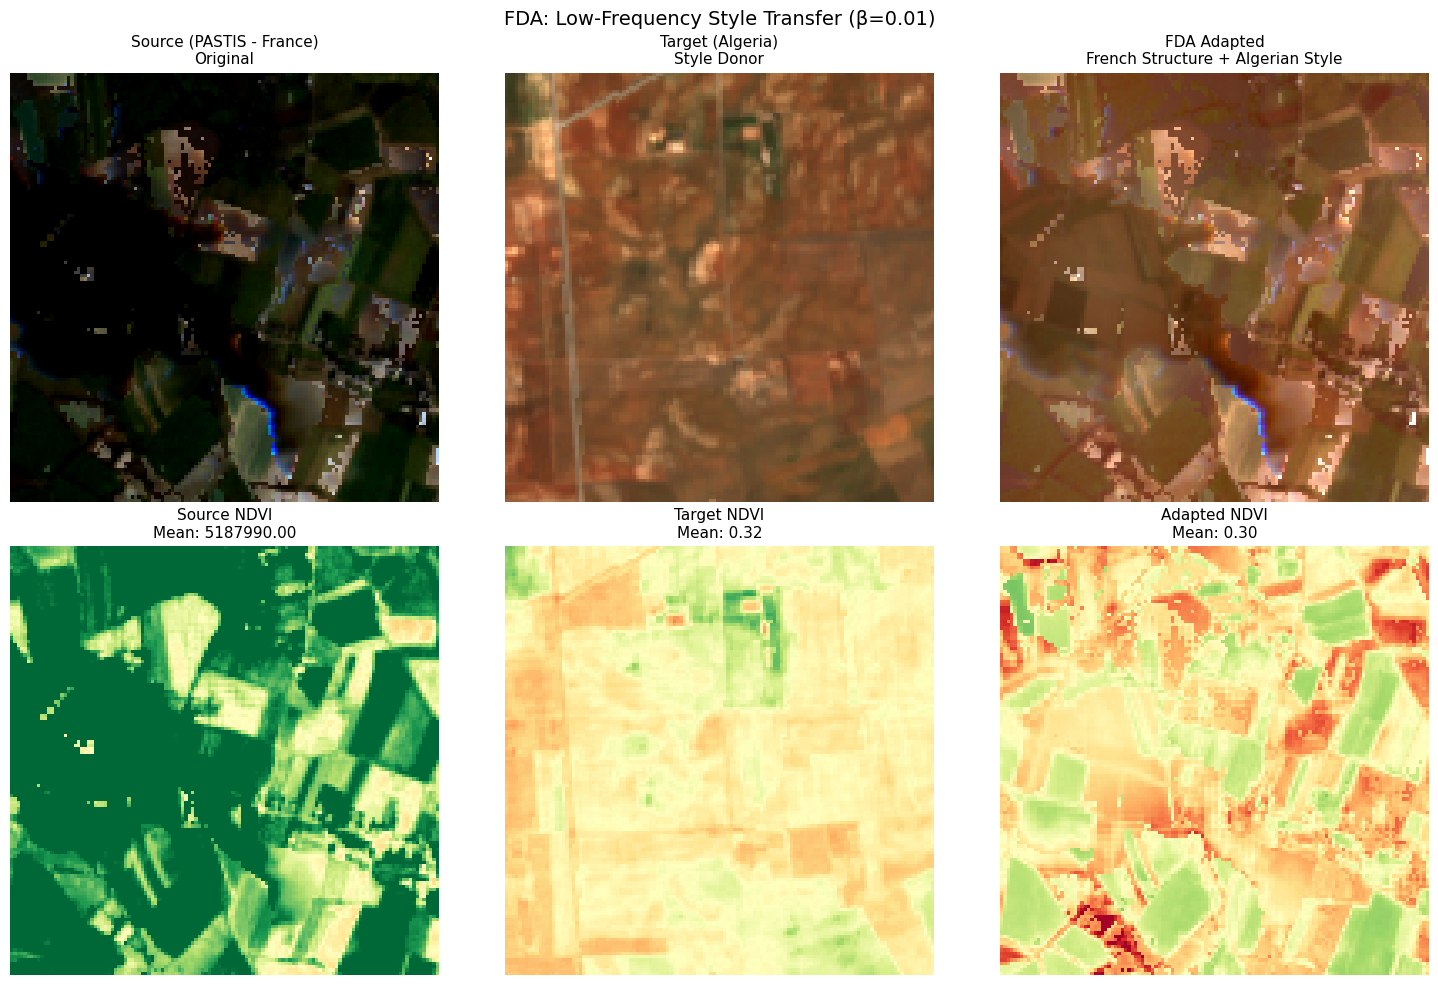


✓ Structure (edges, shapes) preserved from Source
✓ Style (colors, brightness) transferred from Target


In [3]:
# Visualize FDA result: Source vs Target vs Adapted
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

def normalize_rgb(img, scale=3000):
    """Normalize for RGB display"""
    rgb = np.stack([img[2], img[1], img[0]], axis=-1)  # B4, B3, B2
    return np.clip(rgb / scale, 0, 1)

def compute_ndvi(img):
    """Compute NDVI from (C, H, W) image"""
    red = img[2].astype(np.float32)
    nir = img[6].astype(np.float32)
    return (nir - red) / (nir + red + 1e-8)

# Row 1: RGB comparison
axes[0, 0].imshow(normalize_rgb(source_sample))
axes[0, 0].set_title('Source (PASTIS - France)\nOriginal', fontsize=11)
axes[0, 0].axis('off')

axes[0, 1].imshow(normalize_rgb(target_sample))
axes[0, 1].set_title('Target (Algeria)\nStyle Donor', fontsize=11)
axes[0, 1].axis('off')

axes[0, 2].imshow(normalize_rgb(adapted_sample))
axes[0, 2].set_title('FDA Adapted\nFrench Structure + Algerian Style', fontsize=11)
axes[0, 2].axis('off')

# Row 2: NDVI comparison (structure should be preserved)
ndvi_source = compute_ndvi(source_sample)
ndvi_target = compute_ndvi(target_sample)
ndvi_adapted = compute_ndvi(adapted_sample)

im1 = axes[1, 0].imshow(ndvi_source, cmap='RdYlGn', vmin=-0.2, vmax=0.9)
axes[1, 0].set_title(f'Source NDVI\nMean: {ndvi_source.mean():.2f}', fontsize=11)
axes[1, 0].axis('off')

im2 = axes[1, 1].imshow(ndvi_target, cmap='RdYlGn', vmin=-0.2, vmax=0.9)
axes[1, 1].set_title(f'Target NDVI\nMean: {ndvi_target.mean():.2f}', fontsize=11)
axes[1, 1].axis('off')

im3 = axes[1, 2].imshow(ndvi_adapted, cmap='RdYlGn', vmin=-0.2, vmax=0.9)
axes[1, 2].set_title(f'Adapted NDVI\nMean: {ndvi_adapted.mean():.2f}', fontsize=11)
axes[1, 2].axis('off')

plt.suptitle('FDA: Low-Frequency Style Transfer (β=0.01)', fontsize=14)
plt.tight_layout()
plt.show()

print("\n✓ Structure (edges, shapes) preserved from Source")
print("✓ Style (colors, brightness) transferred from Target")

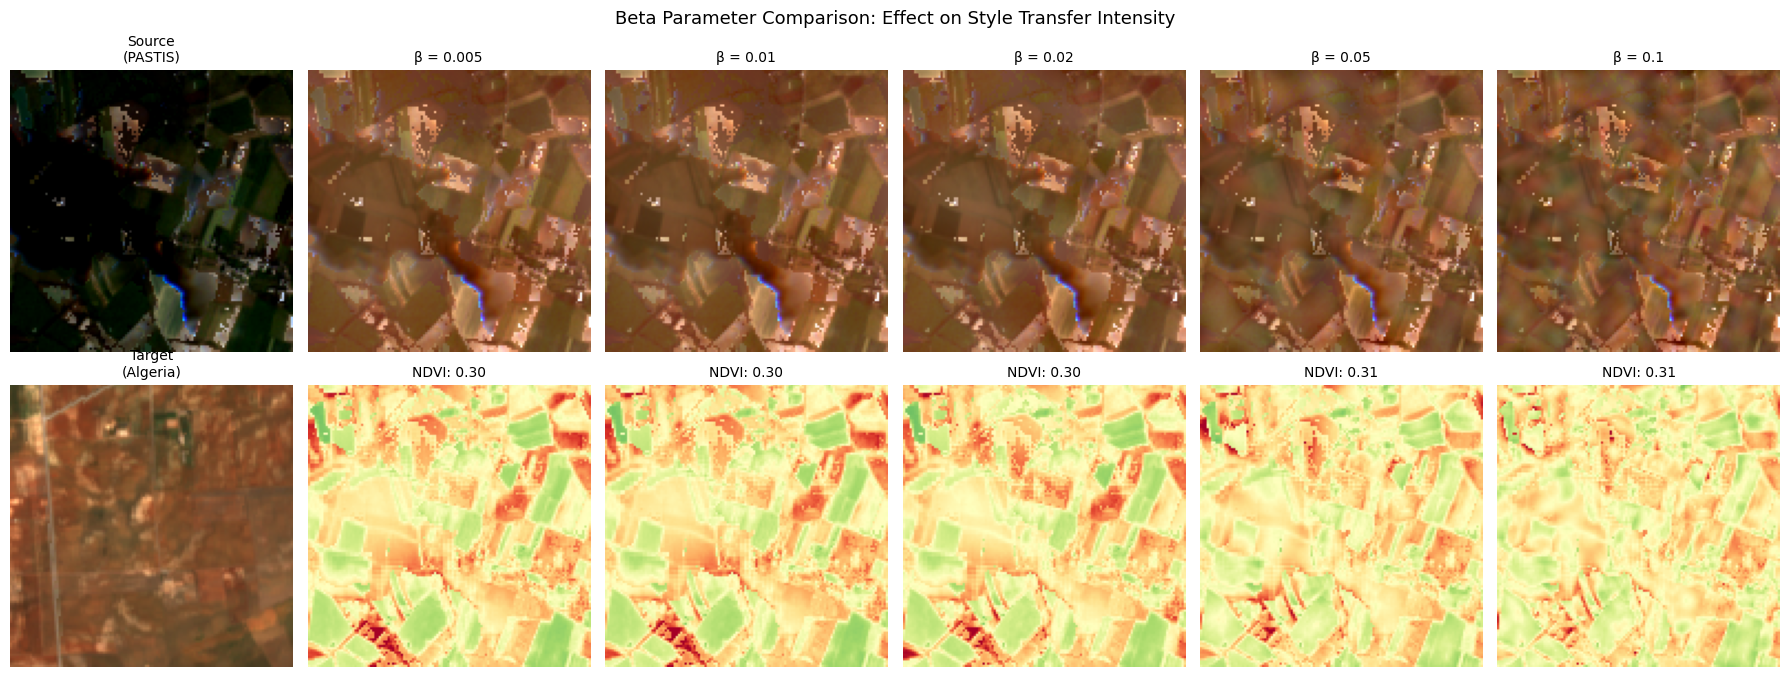


Recommendation:
- β=0.01: Subtle adaptation, minimal artifacts
- β=0.02-0.05: Good balance of adaptation strength
- β>0.05: Risk of artifacts (check for ringing/blur)


In [4]:
# Test different beta values to find optimal setting
betas = [0.005, 0.01, 0.02, 0.05, 0.1]

fig, axes = plt.subplots(2, len(betas) + 1, figsize=(18, 7))

# First column: Original source and target
axes[0, 0].imshow(normalize_rgb(source_sample))
axes[0, 0].set_title('Source\n(PASTIS)', fontsize=10)
axes[0, 0].axis('off')

axes[1, 0].imshow(normalize_rgb(target_sample))
axes[1, 0].set_title('Target\n(Algeria)', fontsize=10)
axes[1, 0].axis('off')

# Test each beta
for i, beta in enumerate(betas):
    adapted = fda_transfer(source_sample, target_sample, beta=beta)
    
    # RGB
    axes[0, i+1].imshow(normalize_rgb(adapted))
    axes[0, i+1].set_title(f'β = {beta}', fontsize=10)
    axes[0, i+1].axis('off')
    
    # NDVI
    ndvi = compute_ndvi(adapted)
    axes[1, i+1].imshow(ndvi, cmap='RdYlGn', vmin=-0.2, vmax=0.9)
    axes[1, i+1].set_title(f'NDVI: {ndvi.mean():.2f}', fontsize=10)
    axes[1, i+1].axis('off')

plt.suptitle('Beta Parameter Comparison: Effect on Style Transfer Intensity', fontsize=13)
plt.tight_layout()
plt.show()

print("\nRecommendation:")
print("- β=0.01: Subtle adaptation, minimal artifacts")
print("- β=0.02-0.05: Good balance of adaptation strength")
print("- β>0.05: Risk of artifacts (check for ringing/blur)")

In [ ]:
# Process all PASTIS images with FDA
# Each source image is paired with a randomly selected target image

BETA = 0.01  # Low-frequency swap window size

# Set random seed for reproducibility
random.seed(42)
np.random.seed(42)


import json
metadata_path = TARGET_DIR.parent / 'metadata.geojson'
with open(metadata_path) as f:
    metadata = json.load(f)

train_filenames = {feat['properties']['filename'] for feat in metadata['features'] if feat['properties']['split'] == 'train'}
train_targets = [f for f in target_files if f.name in train_filenames]
val_targets = [f for f in target_files if f.name not in train_filenames]

print(f"Processing {len(source_files)} source images...")
print(f"Using {len(train_targets)} train target images as style donors (validation excluded)")
print(f"Validation targets: {len(val_targets)} (not used for training adaptation)")
print(f"Beta: {BETA}")
print(f"Output: {OUTPUT_DATA_DIR}")

successful = []
failed = []

for src_file in tqdm(source_files, desc="FDA Processing"):
    try:
        # Load source image
        source_img = np.load(src_file)[0]  # Remove batch dim: (10, 128, 128)
        
        # Randomly select a TRAIN target image as style donor (exclude validation)
        tgt_file = random.choice(train_targets)
        target_img = np.load(tgt_file)[0]
        
        # Apply FDA
        adapted_img = fda_transfer(source_img, target_img, beta=BETA)
        
        # Add batch dimension back and convert to int16
        adapted_img = adapted_img[np.newaxis, :, :, :].astype(np.int16)
        
        # Save adapted image (keep same filename)
        output_path = OUTPUT_DATA_DIR / src_file.name
        np.save(output_path, adapted_img)
        
        successful.append(src_file.name)
        
    except Exception as e:
        failed.append((src_file.name, str(e)))

print(f"\n✓ Successfully processed: {len(successful)} images")
print(f"✗ Failed: {len(failed)} images")

if failed:
    print("\nFailed files:")
    for name, error in failed[:5]:
        print(f"  {name}: {error}")

Processing 2433 source images...
Using 101 train target images as style donors (validation excluded)
Validation targets: 92 (not used for training adaptation)
Beta: 0.01
Output: /home/crop/Desktop/crop2/output/fda_adapted/DATA_S2


FDA Processing: 100%|██████████| 2433/2433 [00:25<00:00, 93.68it/s]


✓ Successfully processed: 2433 images
✗ Failed: 0 images


In [6]:
# Copy annotations (labels remain the same since structure is preserved)
src_ann_dir = Path('/home/crop/Desktop/crop2/output/pastis_maxndvi/ANNOTATIONS')
ann_files = list(src_ann_dir.glob('*.npy'))

print(f"Copying {len(ann_files)} annotation files...")

for ann_file in tqdm(ann_files, desc="Copying annotations"):
    shutil.copy(ann_file, OUTPUT_ANN_DIR / ann_file.name)

print(f"\n✓ Annotations copied to: {OUTPUT_ANN_DIR}")
print(f"  Total: {len(list(OUTPUT_ANN_DIR.glob('*.npy')))} files")

Copying 2433 annotation files...


Copying annotations: 100%|██████████| 2433/2433 [00:00<00:00, 20835.61it/s]


✓ Annotations copied to: /home/crop/Desktop/crop2/output/fda_adapted/ANNOTATIONS
  Total: 2433 files


FDA Adaptation Complete - Final Verification


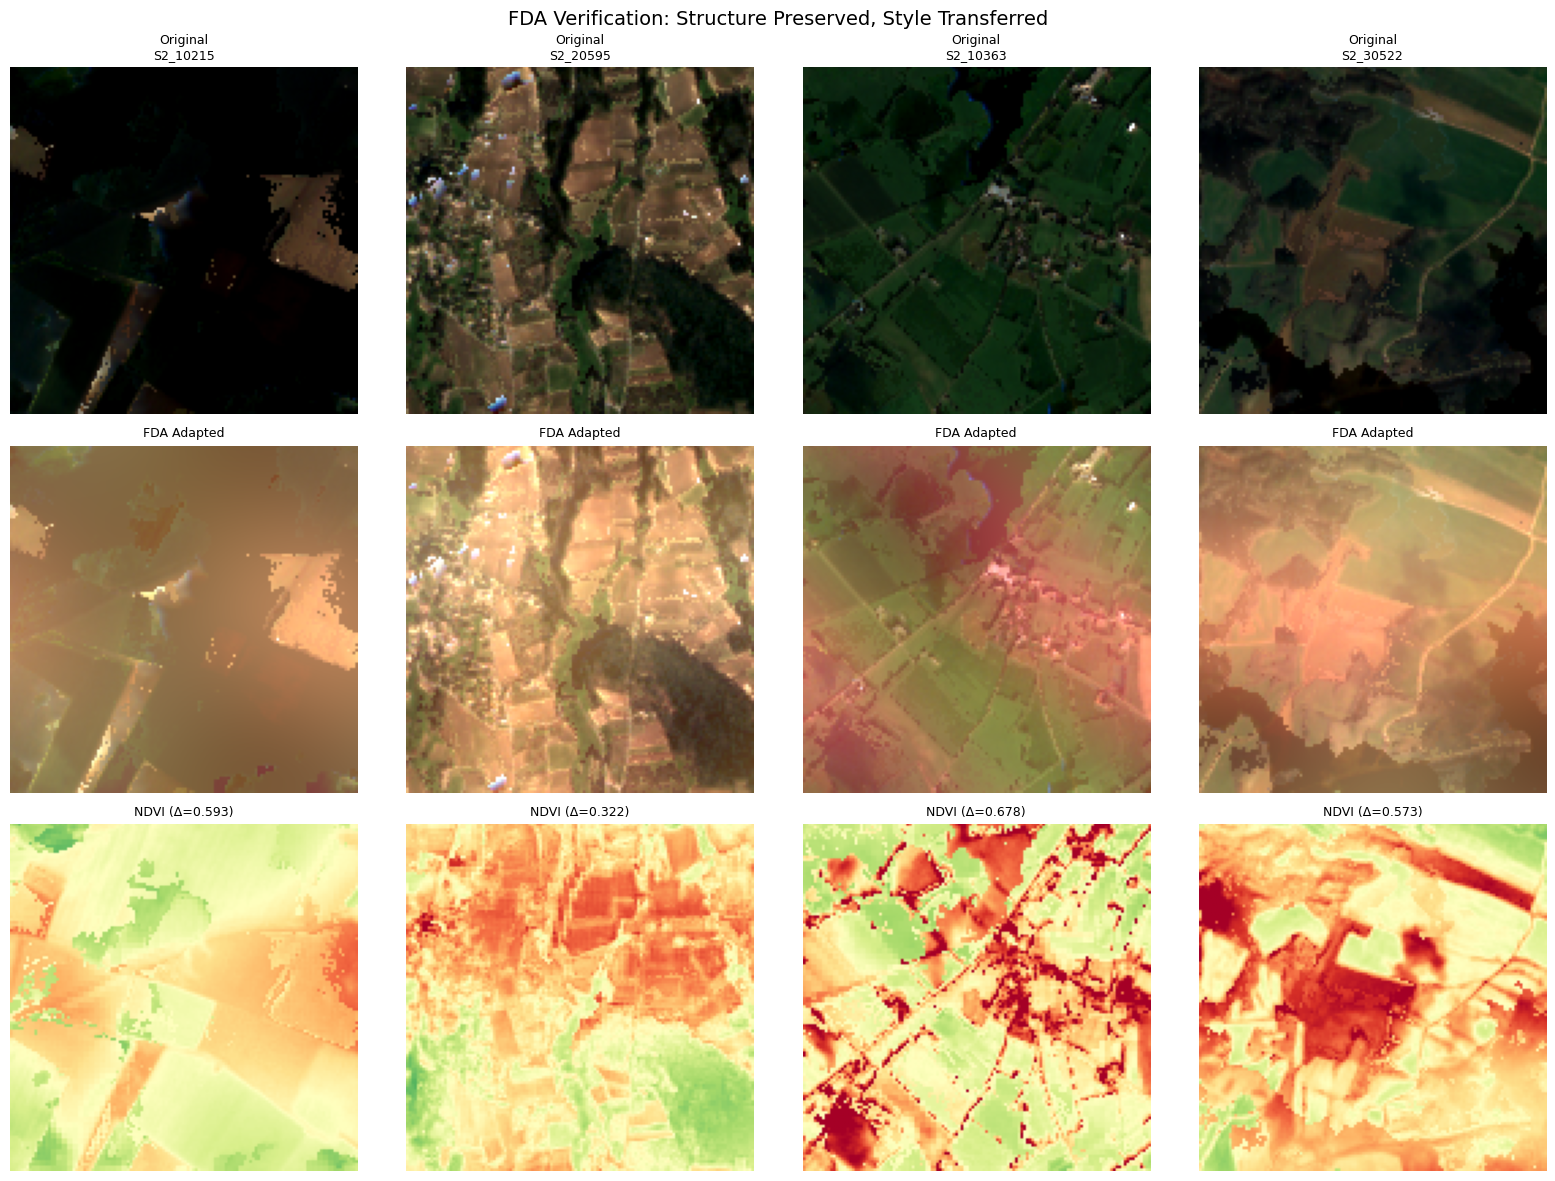


Output Summary:
  Location: /home/crop/Desktop/crop2/output/fda_adapted
  DATA_S2: 2433 adapted images
  ANNOTATIONS: 2433 label files
  Beta used: 0.01

✓ FDA-adapted training set ready for Swin Transformer!


In [7]:
# Final Verification: Visualize random FDA-adapted samples
print("=" * 60)
print("FDA Adaptation Complete - Final Verification")
print("=" * 60)

# Load some adapted samples
adapted_files = sorted(OUTPUT_DATA_DIR.glob('*.npy'))
random.seed(123)
sample_adapted = random.sample(adapted_files, min(4, len(adapted_files)))

fig, axes = plt.subplots(3, 4, figsize=(16, 12))

for i, f in enumerate(sample_adapted):
    # Load adapted
    adapted = np.load(f)[0]
    
    # Load original source for comparison
    original_file = SOURCE_DIR / f.name
    original = np.load(original_file)[0]
    
    # Row 0: Original PASTIS
    axes[0, i].imshow(normalize_rgb(original))
    axes[0, i].set_title(f'Original\n{f.stem}', fontsize=9)
    axes[0, i].axis('off')
    
    # Row 1: FDA Adapted
    axes[1, i].imshow(normalize_rgb(adapted))
    axes[1, i].set_title('FDA Adapted', fontsize=9)
    axes[1, i].axis('off')
    
    # Row 2: NDVI comparison
    ndvi_orig = compute_ndvi(original)
    ndvi_adapt = compute_ndvi(adapted)
    diff = np.abs(ndvi_orig - ndvi_adapt).mean()
    
    axes[2, i].imshow(ndvi_adapt, cmap='RdYlGn', vmin=-0.2, vmax=0.9)
    axes[2, i].set_title(f'NDVI (Δ={diff:.3f})', fontsize=9)
    axes[2, i].axis('off')

axes[0, 0].set_ylabel('Original', fontsize=11)
axes[1, 0].set_ylabel('FDA Adapted', fontsize=11)
axes[2, 0].set_ylabel('NDVI', fontsize=11)

plt.suptitle('FDA Verification: Structure Preserved, Style Transferred', fontsize=14)
plt.tight_layout()
plt.show()

# Summary statistics
print(f"\nOutput Summary:")
print(f"  Location: {OUTPUT_DIR}")
print(f"  DATA_S2: {len(list(OUTPUT_DATA_DIR.glob('*.npy')))} adapted images")
print(f"  ANNOTATIONS: {len(list(OUTPUT_ANN_DIR.glob('*.npy')))} label files")
print(f"  Beta used: {BETA}")
print(f"\n✓ FDA-adapted training set ready for Swin Transformer!")